In [ ]:
import time
from datetime import timedelta
import os
import argparse
import torch
import torch.nn.functional as F
from transformers import (
    AutoTokenizer,
    AutoModel,
    WhisperProcessor
)
from sentence_transformers import SentenceTransformer
from collections import OrderedDict
from tqdm import tqdm
from matplotlib import pyplot as plt
from pprint import pprint

from config import WhiSBERTConfig, CACHE_DIR, CHECKPOINT_DIR
from model import WhiSBERTModel
from data import AudioDataset, collate
from train import load_models
from utils import (
    mean_pooling,
    cos_sim_loss,
    sim_clr_loss,
    norm_temp_ce_loss
)


os.environ["TOKENIZERS_PARALLELISM"] = "false"
BASE_DIR = os.path.join(os.path.dirname(os.path.abspath(__file__)), '..')

In [ ]:
config = WhiSBERTConfig(pooling_mode='mean', use_sbert_layers=False, batch_size=8, device='cuda')
processor, _, _ = load_models(config, '')

/cronus_data/rrao/conda_envs/speech/lib/python3.10/site-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(



Available GPU IDs: [0, 1, 2, 3]
	GPU 0: NVIDIA RTX A6000
	GPU 1: NVIDIA RTX A6000
	GPU 2: NVIDIA RTX A6000
	GPU 3: NVIDIA RTX A6000



In [17]:
print('Preprocessing AudioDataset...')
dataset = AudioDataset('/cronus_data/rrao/wtc_clinic/whisper_segments_transripts.csv', processor)
mini_size = int(0.1 * len(dataset))
drop_size = len(dataset) - mini_size
mini_dataset, _ = torch.utils.data.random_split(dataset, [mini_size, drop_size])

# Calculate lengths for the train/val split (80:20)
total_size = len(mini_dataset)
train_size = int(0.8 * total_size)  # 80% for training
val_size = total_size - train_size  # 20% for validation
# Perform the split
train_dataset, val_dataset = torch.utils.data.random_split(mini_dataset, [train_size, val_size])
print(f'\tTotal dataset size (N): {total_size}')
print(f'\tTraining dataset size (N): {train_size}')
print(f'\tValidation dataset size (N): {val_size}')

Preprocessing AudioDataset...
	Total dataset size (N): 15518
	Training dataset size (N): 12414
	Validation dataset size (N): 3104


In [19]:
data_loader = torch.utils.data.DataLoader(
    val_dataset,
    batch_size=config.batch_size,
    num_workers=config.num_workers,
    shuffle=config.shuffle,
    collate_fn=collate
)

In [20]:
batch = next(iter(data_loader))
print(batch['audio_inputs'].shape)
print(len(batch['text']))

torch.Size([8, 80, 3000])
8


In [25]:
# Whisper-based tokenization
with torch.no_grad():
    outputs = processor.tokenizer(
        batch['text'],
        padding=True,
        truncation=True,
        max_length=512,
        return_tensors='pt'
    ).to(config.device)

In [21]:
whisper_model = WhisperModel.from_pretrained(
    'openai/whisper-small',
    cache_dir=CACHE_DIR
).to(config.device)

In [27]:
embs = whisper_model(
    batch['audio_inputs'].to(config.device),
    decoder_input_ids=outputs['input_ids'],
    decoder_attention_mask=outputs['attention_mask']
).last_hidden_state
embs.shape

Passing a tuple of `past_key_values` is deprecated and will be removed in Transformers v4.43.0. You should pass an instance of `EncoderDecoderCache` instead, e.g. `past_key_values=EncoderDecoderCache.from_legacy_cache(past_key_values)`.


torch.Size([8, 24, 768])

In [22]:
sbert_model = SentenceTransformer(
    'sentence-transformers/all-mpnet-base-v2',
    cache_folder=CACHE_DIR,
    device=config.device
)
sbert_model

/cronus_data/rrao/conda_envs/speech/lib/python3.10/site-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


SentenceTransformer(
  (0): Transformer({'max_seq_length': 384, 'do_lower_case': False}) with Transformer model: MPNetModel 
  (1): Pooling({'word_embedding_dimension': 768, 'pooling_mode_cls_token': False, 'pooling_mode_mean_tokens': True, 'pooling_mode_max_tokens': False, 'pooling_mode_mean_sqrt_len_tokens': False, 'pooling_mode_weightedmean_tokens': False, 'pooling_mode_lasttoken': False, 'include_prompt': True})
  (2): Normalize()
)

In [35]:
sbert_model[0].module

AttributeError: 'Transformer' object has no attribute 'module'

In [2]:
config = WhiSBERTConfig(pooling_mode='cls', use_sbert_layers=False, batch_size=8, device='cuda')
processor, whisbert, sbert = load_models(config, '')

/cronus_data/rrao/conda_envs/speech/lib/python3.10/site-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(



Available GPU IDs: [0, 1, 2, 3]
	GPU 0: NVIDIA RTX A6000
	GPU 1: NVIDIA RTX A6000
	GPU 2: NVIDIA RTX A6000
	GPU 3: NVIDIA RTX A6000



In [3]:
print('Preprocessing AudioDataset...')
dataset = AudioDataset('/cronus_data/rrao/wtc_clinic/whisper_segments_transripts.csv', whisper_processor)
mini_size = int(0.1 * len(dataset))
drop_size = len(dataset) - mini_size
mini_dataset, _ = torch.utils.data.random_split(dataset, [mini_size, drop_size])

# Calculate lengths for the train/val split (80:20)
total_size = len(mini_dataset)
train_size = int(0.8 * total_size)  # 80% for training
val_size = total_size - train_size  # 20% for validation
# Perform the split
train_dataset, val_dataset = torch.utils.data.random_split(mini_dataset, [train_size, val_size])
print(f'\tTotal dataset size (N): {total_size}')
print(f'\tTraining dataset size (N): {train_size}')
print(f'\tValidation dataset size (N): {val_size}')

Preprocessing AudioDataset...
	Total dataset size (N): 15518
	Training dataset size (N): 12414
	Validation dataset size (N): 3104


In [4]:
data_loader = torch.utils.data.DataLoader(val_dataset, batch_size=config.batch_size, num_workers=config.num_workers, shuffle=config.shuffle, collate_fn=collate)

In [5]:
batch = next(iter(data_loader))
print(batch['audio_inputs'].shape)
print(len(batch['text']))

torch.Size([8, 80, 3000])
8


In [25]:
sbert = SentenceTransformer(
    'sentence-transformers/all-mpnet-base-v2',
    cache_folder='/cronus_data/rrao/cache',
    device='cuda'
)
sbert = torch.nn.DataParallel(sbert, device_ids=[0, 1, 2, 3])
sbert.eval()

/cronus_data/rrao/conda_envs/speech/lib/python3.10/site-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


DataParallel(
  (module): SentenceTransformer(
    (0): Transformer({'max_seq_length': 384, 'do_lower_case': False}) with Transformer model: MPNetModel 
    (1): Pooling({'word_embedding_dimension': 768, 'pooling_mode_cls_token': False, 'pooling_mode_mean_tokens': True, 'pooling_mode_max_tokens': False, 'pooling_mode_mean_sqrt_len_tokens': False, 'pooling_mode_weightedmean_tokens': False, 'pooling_mode_lasttoken': False, 'include_prompt': True})
    (2): Normalize()
  )
)

In [23]:
isinstance(sbert, torch.nn.DataParallel)

False

In [ ]:
sbert[0]

In [21]:
sbert_embs = torch.tensor(sbert.module.encode(batch['text']))
print(sbert_embs)
print(sbert_embs.shape)

tensor([[-0.0131,  0.0750, -0.0033,  ..., -0.0039,  0.0381,  0.0133],
        [ 0.0946,  0.0082, -0.0399,  ...,  0.0269,  0.0126,  0.0157],
        [-0.0012,  0.0770, -0.0190,  ...,  0.0474,  0.0232,  0.0088],
        ...,
        [-0.0128,  0.0325, -0.0011,  ...,  0.0261,  0.0054, -0.0362],
        [-0.0141,  0.0015,  0.0005,  ...,  0.0501,  0.0182, -0.0013],
        [ 0.0190,  0.0469, -0.0361,  ...,  0.0181,  0.0243, -0.0187]])
torch.Size([8, 768])


In [7]:
_, whisbert_untrained, _, _ = load_models(config, '')

/cronus_data/rrao/conda_envs/speech/lib/python3.10/site-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(
Some weights of RobertaModel were not initialized from the model checkpoint at FacebookAI/roberta-base and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [8]:
whisbert_untrained.eval()

with torch.no_grad():
    outputs = whisper_processor.tokenizer(
        batch['text'],
        padding=True,
        truncation=True,
        max_length=512,
        return_tensors='pt'
    )
    whisbert_u_embs = whisbert_untrained(batch['audio_inputs'], text_input_ids=outputs['input_ids'], text_attention_mask=outputs['attention_mask'])

print(whisbert_u_embs.shape)

Passing a tuple of `past_key_values` is deprecated and will be removed in Transformers v4.43.0. You should pass an instance of `EncoderDecoderCache` instead, e.g. `past_key_values=EncoderDecoderCache.from_legacy_cache(past_key_values)`.


torch.Size([16, 768])


In [9]:
whisbert_trained.eval()

with torch.no_grad():
    outputs = whisper_processor.tokenizer(
        batch['text'],
        padding=True,
        truncation=True,
        max_length=512,
        return_tensors='pt'
    )
    whisbert_t_embs = whisbert_trained(batch['audio_inputs'], text_input_ids=outputs['input_ids'], text_attention_mask=outputs['attention_mask'])

print(whisbert_t_embs.shape)

torch.Size([16, 768])


In [10]:
print(roberta_embs)
print(whisbert_u_embs)
print(whisbert_t_embs)

tensor([[-0.0993,  0.1067,  0.0027,  ..., -0.0902, -0.0371, -0.0233],
        [-0.0891,  0.1118,  0.0148,  ..., -0.0653, -0.0502, -0.0265],
        [-0.0745,  0.0700, -0.0422,  ..., -0.0651, -0.0402, -0.0374],
        ...,
        [-0.0815,  0.0782, -0.0371,  ..., -0.0739, -0.0347, -0.0360],
        [-0.1056,  0.1056, -0.0154,  ..., -0.0551, -0.0270, -0.0450],
        [-0.1187,  0.1556, -0.0052,  ..., -0.1198, -0.0507, -0.0172]])
tensor([[ -3.1382,  -1.7092,   9.1477,  ...,   5.5499,   4.3223,  -5.1145],
        [ -7.4380,  -4.1652,  -7.2116,  ...,   0.5559,  -4.2234,   5.0763],
        [ -6.5615,   4.7952,   9.5207,  ...,   6.2802,   2.1562,  -6.8492],
        ...,
        [  1.0966,   6.9145,   5.4920,  ...,  -2.4419,   0.1266,  -4.1704],
        [ -5.4724,  -2.8005,  -0.5699,  ...,   5.7909,   2.9442,  -3.6782],
        [-16.4777,  -0.1498,   1.5240,  ...,   6.9775,  -3.6257,  -0.2927]])
tensor([[-1.3900,  1.6551, -0.2166,  ..., -1.0271, -0.7292, -0.6569],
        [-1.3900,  1.6543,

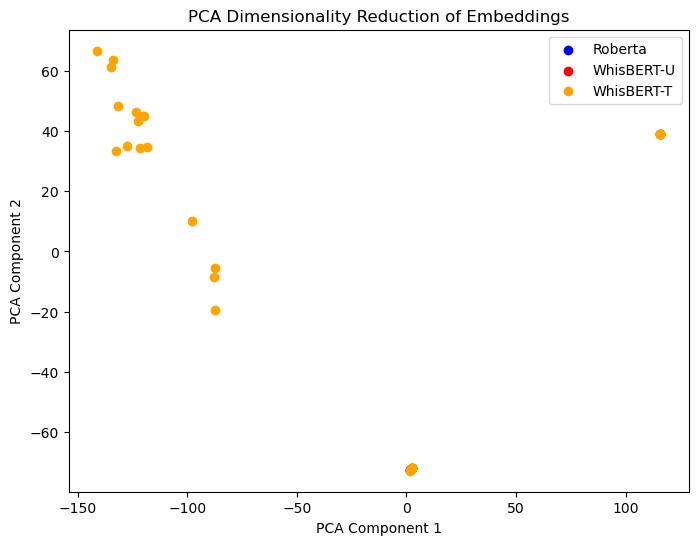

In [11]:
# Stack embeddings for PCA
all_embs = np.vstack([roberta_embs.numpy(), whisbert_u_embs.numpy(), whisbert_t_embs.numpy()])

# Apply PCA for dimensionality reduction to 2D
pca = PCA(n_components=2)
reduced_embs = pca.fit_transform(all_embs)

# Split the reduced embeddings
reduced_roberta = reduced_embs[:4]
reduced_whisbert_u = reduced_embs[4:8]
reduced_whisbert_t = reduced_embs[8:]

# Create scatter plot
plt.figure(figsize=(8, 6))
plt.scatter(reduced_roberta[:, 0], reduced_roberta[:, 1], color='blue', label='Roberta')
plt.scatter(reduced_whisbert_u[:, 0], reduced_whisbert_u[:, 1], color='red', label='WhisBERT-U')
plt.scatter(reduced_whisbert_t[:, 0], reduced_whisbert_t[:, 1], color='orange', label='WhisBERT-T')

plt.title("PCA Dimensionality Reduction of Embeddings")
plt.legend()
plt.xlabel("PCA Component 1")
plt.ylabel("PCA Component 2")
plt.show()

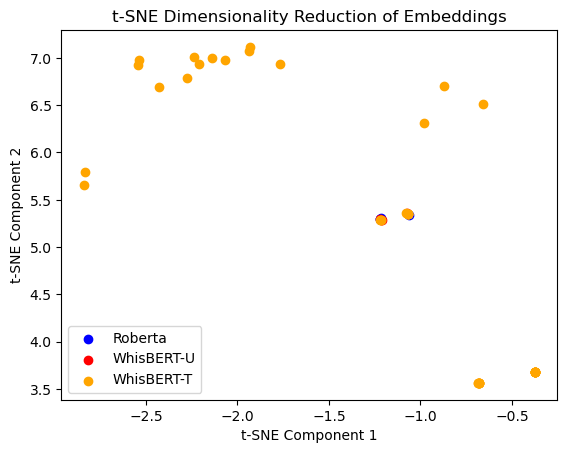

In [12]:
# Stack embeddings for t-SNE
all_embs = np.vstack([roberta_embs.numpy(), whisbert_u_embs.numpy(), whisbert_t_embs.numpy()])

# Apply t-SNE for dimensionality reduction
tsne = TSNE(n_components=2, random_state=42)
reduced_embs = tsne.fit_transform(all_embs)

# Split the reduced embeddings
reduced_roberta = reduced_embs[:4]
reduced_whisbert_u = reduced_embs[4:8]
reduced_whisbert_t = reduced_embs[8:]

# Create scatter plot
# plt.figure(figsize=(8, 6))
plt.scatter(reduced_roberta[:, 0], reduced_roberta[:, 1], color='blue', label='Roberta')
plt.scatter(reduced_whisbert_u[:, 0], reduced_whisbert_u[:, 1], color='red', label='WhisBERT-U')
plt.scatter(reduced_whisbert_t[:, 0], reduced_whisbert_t[:, 1], color='orange', label='WhisBERT-T')

plt.title("t-SNE Dimensionality Reduction of Embeddings")
plt.legend()
plt.xlabel("t-SNE Component 1")
plt.ylabel("t-SNE Component 2")
plt.show()